In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
#import random 
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.integrate import odeint

#for plotting
from numpy import loadtxt
from pylab import figure, plot, xlabel, grid, legend, title, savefig
from matplotlib.font_manager import FontProperties
import warnings

In [2]:
%matplotlib inline
#pd.set_option('display.max_rows', None)
#suppress warnings
warnings.filterwarnings('ignore')

In [3]:
#number of simulation n
n=1e6;
n=int(n)
#length of Quad = 50.45*2.54/100;
L=50.45*2.54/100;

In [4]:
from scipy.stats import maxwell
r_maxwell = maxwell.rvs(size=n);

In [5]:
#using cartesian co-ordinate
x0 = np.random.uniform(-0.00445, 0.00445,n);#assuming x max and y max to be 0.445 cm
y0 = np.random.uniform(-0.00445, 0.00445,n);
z0 = 0;
rand1p=np.random.uniform(0,1,n);
rand1=np.sqrt(rand1p)
rand2p=np.random.uniform(0,1,n);
rand2=np.sqrt(rand2p)
#binary 
p1=np.random.choice([-1,1], n) 
p2=np.random.choice([-1,1], n) 

In [6]:
theta = np.arcsin(rand1)
theta1 = np.arcsin(rand2)

In [7]:
m_He=3*1.67*10**(-27)
kB=1.38*10**(-23)
T=1.3
v0 = math.sqrt(3*kB*T/m_He)
v0

103.64610446157577

In [8]:
v=v0 * r_maxwell
dframe=pd.DataFrame({'x0':x0,'y0':y0,'theta':theta, 'theta1':theta1,'v':v})
dframe['vx']=(1-np.cos(dframe['theta']))*v
dframe['vy']=(1-np.cos(dframe['theta1']))*v
dframe['vz']=(dframe['v']**2-dframe['vx']**2-dframe['vy'])**0.5
dframe['p1']=p1
dframe['p2']=p2
vx=v0*(1-np.cos(theta))
vy=v0*(1-np.cos(theta1))

vz_sq= (v**2-vx**2-vy**2)

mask = (vz_sq > 0) 
# make vz=0 for those events which will have (vx^2 + vy^2)^0.5 > vz

vz = 0+ mask*(vz_sq)**0.5

In [9]:
df=pd.DataFrame({'x0':dframe['x0'],'y0':dframe['y0'],'z0':z0, 'vx':dframe['vx']*dframe['p1'], 'vy':dframe['vy']*dframe['p2'], 'vz':dframe['vz']})

In [10]:
# first circle of radius 0.2677/2 inch = 0.339979 cm is at z=5.65847484 cm
# calculate time to travel this distance
df ['t'] = 0.0565847484/df ['vz'];
# second circle of radius 0.2677/2 inch = 0.339979 cm is at z=16.65667484 cm
df['t_2'] = 0.1665667484/df['vz']
#the quad start at z = 23.32167294 cm
df['t_3'] = 0.2332167294/df['vz']
#Quad end at z = 1.5332167294/df['vz']
#df['t_f'] = 1.5332167294 / df['vz']

In [11]:
df['x_1']=df['x0']+df['vx']*df['t']
df['y_1']=df['y0']+df['vy']*df['t']
df['r_1']=(df['x_1']**2+df['y_1']**2)**0.5

In [12]:
df1 = df.loc[(df['r_1'] < 0.00339979 )]
df1=df1.reset_index(drop=True)

In [13]:
df1['x_2']=df1['x0']+df1['vx']*df1['t_2']
df1['y_2']=df1['y0']+df1['vy']*df1['t_2']
df1['r_2']=(df1['x_2']**2+df1['y_2']**2)**0.5

In [14]:
# Lets cut those who have greater radius than 10 m (large ring in a aparatus)
df2 = df1.loc[(df1['r_2'] < 0.00339979 )]
df2=df2.reset_index(drop=True)

In [15]:
df2['x_3']=df2['x0']+df2['vx']*df2['t_3']
df2['y_3']=df2['y0']+df2['vy']*df2['t_3']
df2['r_3']=(df2['x_3']**2+df2['y_3']**2)**0.5
df2['t_f']=L/df2['vz']

In [16]:
#start simulation inside Quad:
#Length of the quad is 1.3 m;
#Nuclear magneton mu_N=5.051*10^-27;
mu_N=5.051*10**-27;
#magnetic moment of He3 is -2.2905*mu_N;
mu_n=-2.2905*mu_N;
#length of Quad = 50.45*2.54/100;
L=50.45*2.54/100;
#mass of proton, m_p = 1.67*10^-27 kg
m_p = 1.672621 * 10**-27;
m_n = 1.67493  * 10**-27;
#Diffrential equation constant K = mu_n * Qxy/(m_He3)
#Qxy is the gradient of the quardupole magnet 
Qxy=100; #Qxy =1 T/cm
k = mu_n * Qxy /(2*m_p + m_n)
#for the easier solution I choose K = -K 
K=-k
K

230.45655607019046

In [17]:
def vectorfield(w, t, k):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        k :  vector of the parameters:
                  p = [k1 or k2]
    """
    x1, y1, x2, y2 = w

    # Create f = (x1',y1',x2',y2'):
    f = [y1,
         -k*x1/(x1**2+x2**2)**0.5,
         y2,
         -k*x2/(x1**2+x2**2)**0.5]
    return f

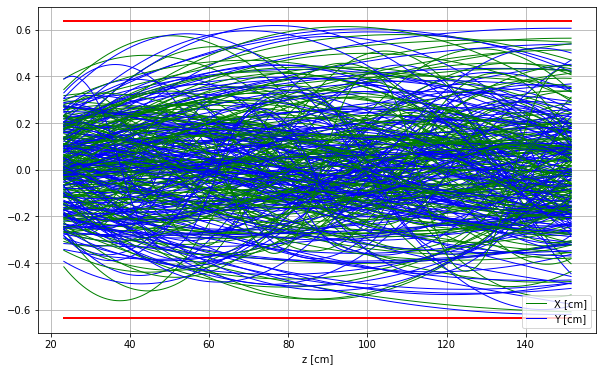

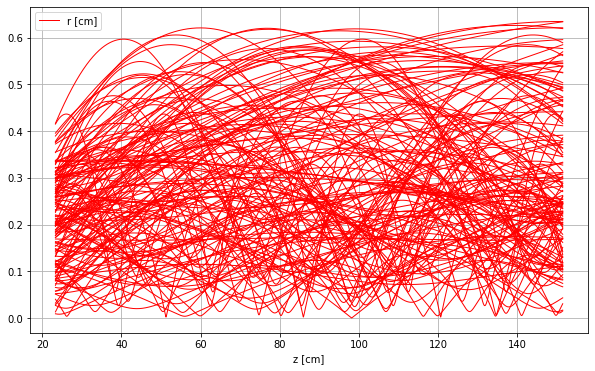

In [18]:
DF = pd.DataFrame(columns=['x_f', 'vx_f', 'y_f','vy_f','vz_f'])
count=0
for index, row in df2.iterrows():
    if count >=500:
        break   
    
    # Parameter values
    # modified spring constants
    k1 = K; #for spin parallel
    k2 = -K; # for anaother spin state
    # Initial conditions
    # x1 and x2 are the initial displacements; y1 and y2 are the initial velocities
    x1 = row['x_3']
    x2 = row['y_3']
    y1 = row['vx']
    y2 = row['vy']
    y3 = row['vz']
    mas = 0.00635 #diameter of the cylinder = 0.5 inch
    #print(x1,x2,y1,y2)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    stoptime = row['t_f']
    numpoints = 2500
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

    # Pack up the parameters and initial conditions:
    p = k1 #select k1 for parallel He3 spin and k2 for antiparallel He3 spin
    w0 = [x1, y1, x2, y2]

    # Call the ODE solver.
    wsol = odeint(vectorfield, w0, t, args=(p,),
                  atol=abserr, rtol=relerr)
    X=wsol[-1]
    columns=['x_f', 'vx_f', 'y_f','vy_f']
    DFX = pd.DataFrame(X.reshape(-1, len(X)),columns=columns)
    #DFX=pd.DataFrame({'x_f':X[0], 'vx_f':X[1], 'y_f':X[2],'vy_f':X[3]})
    DFX['vz_f'] = y3; 
    with open('two_springs.dat', 'w') as f:
    # Print & save the solution.
        for t1, w1 in zip(t, wsol):
            print(t1, w1[0], w1[1], w1[2], w1[3],file=f)
        f.close()
    t, x1, y1, x2, y2 = loadtxt('two_springs.dat', unpack=True)
    
    df_New=pd.DataFrame({'t':t,'x1':x1,'y1':y1,'x2':x2,'y2':y2,'vz_f':y3,'mas':mas})
    df_New['r2']=(df_New['x1']**2+df_New['x2']**2)**0.5
    df_New1 = df_New.loc[(df_New['r2'] < mas )] # diameter of beam pipe in Quad is 0.5 inch
    df_New1 = df_New1.reset_index(drop=True)
    if (len(df_New.index) != len(df_New1.index)):
        continue
        #if it hit beam pipe at any time, it will be discarded 
    count = count+1
    DF=DF.append(DFX)
    
    #if ((x1**2+x2**2)**0.5>0.127):
        #continue
    figure(1, figsize=(10, 6))

    xlabel('z [cm]')
    #plt.ylabel('X / Y [cm]')
    grid(True)
    #hold(True)
    lw = 1

    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['x2']*100, 'g', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['x1']*100, 'b', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['mas']*100, 'r', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['mas']*-100, 'r', linewidth=lw)
    
    #plt.ylim(-1,1)
    plt.legend(["X [cm]", "Y [cm]"], loc ="lower right")
    
    figure(2, figsize=(10, 6))
    xlabel('z [cm]')
    #plt.ylabel('X / Y [cm]')
    grid(True)
    #hold(True)
    lw = 1

    #plot(t, x1, 'b', linewidth=lw)
    #plot(t, x2, 'g', linewidth=lw)
    plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['r2']*100, 'r', linewidth=lw)
    #plot(df_New1['t']*df_New1['vz_f']*100 + 23.32167294, df_New1['x2']*100, 'g', linewidth=lw)
    #plt.ylim(0,0.75)

    plt.legend(["r [cm]"])
    
#savefig('QuadTrackHe3_SpinParallel.png', dpi=100)

In [19]:
def ConstructAllData(T):
    p=pd.read_csv(T,delim_whitespace=True)
    df           = pd.DataFrame(p)
    #print(df.duplicated().any())
    df_OtherHalf = df.rename(columns={'x': 'y','y': 'x'})
    #print(df_OtherHalf.duplicated().any())
    df_1stq=df.append(df_OtherHalf)
    #print(df_1stq.duplicated().any())
    #print(df_1stq)
    df_2ndq=df_1stq.copy()
    df_2ndq.x=df_2ndq.x*-1
    df_3rdq=df_2ndq.copy()
    df_3rdq.y=df_3rdq.y*-1
    df_4thq=df_1stq.copy()
    df_4thq.y=df_4thq.y*-1
    df_Final=pd.concat([df_1stq, df_2ndq, df_3rdq,df_4thq],ignore_index=True)
    df_Final
    return df_Final

In [20]:
Ring="/mnt/c/Users/Christopher Crawford/Desktop/MagneticFieldFromRing_ABSMagnetSystemGrid_v3New.txt"
QMod='/mnt/c/Users/Christopher Crawford/Desktop/StLineFinalDim_LargeRange_part50-100.txt'
Costheta='/mnt/c/Users/Christopher Crawford/Desktop/CosthetaCoil_FinalLongRange_part50-100FM.txt'
OuterCostheta='/mnt/c/Users/Christopher Crawford/Desktop/OutsideCosthetaCoil200Wies_part50-100.txt'

In [21]:
#Now do the file for 100 to 150 cm 
#QMod='/mnt/c/Users/Christopher Crawford/Desktop/StLineFinalDim_LargeRange_part100-150.txt'
#Costheta='/mnt/c/Users/Christopher Crawford/Desktop/CosthetaCoil_FinalLongRange_part100-150FM.txt'
#OuterCostheta='/mnt/c/Users/Christopher Crawford/Desktop/OutsideCosthetaCoil200Wies_part100-150.txt'

In [22]:
T_QS=ConstructAllData(QMod)
T_QS=T_QS.dropna()
T_QS=T_QS.reset_index(drop=True)
T_QS=T_QS.drop_duplicates(ignore_index=True)

In [23]:
T_OCT=ConstructAllData(OuterCostheta)
T_OCT=T_OCT.dropna()
T_OCT=T_OCT.reset_index(drop=True)
T_OCT=T_OCT.drop_duplicates(ignore_index=True)

In [24]:
T_CT=ConstructAllData(Costheta)
T_CT=T_CT.dropna()
T_CT=T_CT.reset_index(drop=True)
T_CT=T_CT.drop_duplicates(ignore_index=True)
#T_CT

In [25]:
pr=pd.read_csv(Ring,delim_whitespace=True)
T_Ring1 = pd.DataFrame(pr)
T_Ring=T_Ring1.dropna()
T_Ring=T_Ring.reset_index(drop=True)

In [26]:
T_Ring["r"]=T_Ring["r"]*100
T_Ring["z"]=T_Ring["z"]*100-2
#ring coil will be at the location z = 5 cm not 7 cm
T_Ring=T_Ring.round(4)
T_Ring.duplicated().any()

False

In [27]:
T_QS["x"]=T_QS["x"]*100
T_QS["y"]=T_QS["y"]*100
T_QS["z"]=T_QS["z"]*100
#(lets start ring coil at the begining)
T_QS=T_QS.round(4)
T_QS.duplicated().any()

False

In [28]:
T_CT=T_CT.round(4)
T_CT.duplicated().any()
T_CT["z"]=T_CT["z"]+62.5+10+4.5
#we start at 62.5 cm and costheta coil starts at ~5.5cm nad the length of costheta is 9 cm 
#those gives total distance of 5.5 + 9/2 cm = 10 cm 
T_CT

,x,y,z,Bx,By,Bz
0,0.0,0.0,50.0,0.0742,0.0000,-0.0000
1,0.1,0.0,50.0,0.0742,0.0000,0.0013
2,0.2,0.0,50.0,0.0741,0.0000,0.0025
3,0.3,0.0,50.0,0.0741,0.0000,0.0038
4,0.4,0.0,50.0,0.0740,0.0000,0.0051
...,...,...,...,...,...,...
19220860,6.9,-6.4,100.0,0.0557,-0.0448,-0.1020
19220861,6.9,-6.5,100.0,0.0543,-0.0449,-0.1020
19220862,6.9,-6.6,100.0,0.0527,-0.0452,-0.1028
19220863,6.9,-6.7,100.0,0.0512,-0.0459,-0.1048


In [29]:
T_OCT=T_OCT.round(4)
T_OCT.duplicated().any()
T_OCT["z"]=T_OCT["z"]+62.5+60+(2.5/2)
#we start at 62.5 cm and costheta coil starts at ~5.5cm nad the length of costheta is 9 cm 
#those gives total distance of 5.5 + 9/2 cm = 10 cm 
T_OCT

,x,y,z,Bx,By,Bz
0,0.0,0.0,50.0,0.0272,0.0000,0.0001
1,0.1,0.0,50.0,0.0272,0.0000,0.0002
2,0.2,0.0,50.0,0.0272,0.0000,0.0004
3,0.3,0.0,50.0,0.0272,0.0000,0.0005
4,0.4,0.0,50.0,0.0272,0.0000,0.0006
...,...,...,...,...,...,...
19779976,7.0,-6.5,100.0,0.5249,-0.0203,0.2247
19779977,7.0,-6.6,100.0,0.5241,-0.0205,0.2282
19779978,7.0,-6.7,100.0,0.5232,-0.0208,0.2317
19779979,7.0,-6.8,100.0,0.5224,-0.0211,0.2352


In [30]:
def ObtainB0_Ring(x,T_Ring):
    rt=(x[0]**2+x[1]**2)**0.5
    T_Ring["Del"]=((T_Ring["r"]-rt)**2+(T_Ring["z"]-x[2])**2)**0.5
    b=T_Ring["Del"].idxmin()
    a=T_Ring["Del"].min()
    if a>1.05:
        print("Not working as expected in Ring")
    Theta=math.atan2(x[1],x[0])
    Br=T_Ring.iloc[b]["Br"]
    Bz=T_Ring.iloc[b]["Bz"]
    B=[Br*np.cos(Theta),Br*np.sin(Theta),Bz]
    return B

In [31]:
def ObtainB0(x,T):
    T["Del"]=((T["x"]-x[0])**2+(T["y"]-x[1])**2+(T["z"]-x[2])**2)**0.5
    b=T["Del"].idxmin()
    a=T["Del"].min()
    if a>1.1:
        print("Not working as expected in Quad /SIM ")
    B_Q=[T.iloc[b]["Bx"],T.iloc[b]["By"],T.iloc[b]["Bz"]]
    return B_Q

In [32]:
def CombineB0(x,T_Quad, T_OutCos, T_Cos, T_Ring):
    BQ=ObtainB0(x,T_Quad)
    BC=ObtainB0(x,T_Cos)
    BR=ObtainB0_Ring(x,T_Ring)
    BC_O=ObtainB0(x,T_OutCos)
    #BT=[BQ[0]+BR[0]+BC[0]+0.03+BC_O[0],BQ[1]+BR[1]+BC[1]+BC_O[1],BQ[2]+BR[2]+BC[2]+BC_O[2]]
    #adding B5=0.03 -> Constant field inside MSR
    test=[BQ[0]+BR[0]+0.03+BC[0]+BC_O[0],BQ[1]+BR[1]+BC[1]+BC_O[1],BQ[2]+BR[2]+BC[2]+BC_O[2]]
    return test

In [33]:
#start work to calculate polarization
#intial parameters
g=20378.9; 
#v3=22000;
#z_E=(151.4646 + 23.32167294);#initial position before exit of the quad#will use latter
z0=62.5;#end of Quad in COOMSOL<will use for now>
#z0=100.1
#r0=0.629; # for checking (previous r0= 0.629)
z1=100; # distance simulated for the polarization study
#z1=149.9
z_n=z1-z0
num_points=10;

In [34]:
DF
L
DF

,x_f,vx_f,y_f,vy_f,vz_f
0,-0.001965,-0.304658,-0.001178,0.460519,37.645535
0,-0.002591,0.249959,0.002001,0.006668,81.889348
0,0.000908,-0.198990,0.002093,0.217721,238.084787
0,0.001391,-0.879922,0.004328,-0.322853,115.735422
0,0.001204,-0.731342,-0.001608,-0.084613,139.999269
...,...,...,...,...,...
0,-0.001897,-0.326269,0.000967,-0.153770,75.535379
0,-0.001936,-0.201501,0.005634,-0.005295,180.878115
0,-0.000686,0.073248,-0.000625,-0.940325,67.332047
0,0.000040,0.926598,-0.002049,-0.040175,113.834057


Event :1 Polarization 0.9998497857910368, initial coordinate (-0.19654062244925172,-0.11779234450885415), and final co-ordinate (-0.5000204640291044,0.34094668818699236)
Event :2 Polarization 0.9995968510802327, initial coordinate (-0.25908358511351437,0.200054711512103), and final co-ordinate (-0.1446186449371537,0.20310825960191706)
Event :3 Polarization 0.9957087040119736, initial coordinate (0.09083370332225273,0.20933482478722068), and final co-ordinate (0.05949135242252516,0.2436273984337055)
Event :4 Polarization 0.9983481039189462, initial coordinate (0.13908339215818322,0.4328054801325573), and final co-ordinate (-0.14602428978223958,0.3281963112655072)
Event :5 Polarization 0.9986623566429126, initial coordinate (0.12043937963111416,-0.16076017989232388), and final co-ordinate (-0.0754569548374411,-0.18342458869857908)
Event :6 Polarization 0.9992419542571306, initial coordinate (-0.1116891420473198,0.0165532862125088), and final co-ordinate (-0.14639710389078506,-0.362110023

Event :50 Polarization 0.9989365260332014, initial coordinate (0.2571493683696747,-0.1178158860630284), and final co-ordinate (0.28861735970886276,-0.14427181628750255)
Event :51 Polarization 0.9982131873871404, initial coordinate (-0.20044510726694495,0.3039299709297905), and final co-ordinate (-0.17670363785126503,0.02957508113219587)
Event :52 Polarization 0.9998713036200889, initial coordinate (-0.1602325359974475,-0.17212447820073978), and final co-ordinate (0.02376506717007179,0.06509421591110345)
Event :53 Polarization 0.9995581297079378, initial coordinate (0.469650157152953,-0.3224160289061667), and final co-ordinate (0.8660638291828247,-0.15013229415289037)
Event :54 Polarization 0.9780716019885678, initial coordinate (-0.06248598221719992,0.03998002038946044), and final co-ordinate (0.11897266150200694,0.061146621859297354)
Event :55 Polarization 0.9991399732777109, initial coordinate (-0.2247697048761751,0.06459581808946172), and final co-ordinate (-0.04113369160515579,0.04

Event :99 Polarization 0.9993848488016699, initial coordinate (0.12812326081441797,0.031118564730446715), and final co-ordinate (-0.1841468554454305,-0.2535983050285272)
Event :100 Polarization 0.9989270814578187, initial coordinate (-0.2577218722158771,-0.02882167079850124), and final co-ordinate (-0.8382685322780234,-0.12401360347985523)


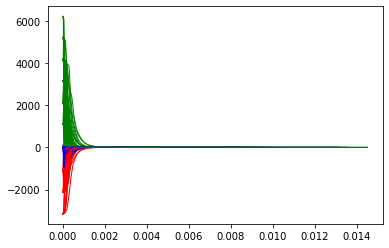

In [35]:
count=0
Pol=[]; 
for index, row in DF.iterrows():
    if count >=100:
        break   
    x0=[row['x_f']*100, row['y_f']*100, z0];
    
    #B0=CombineB0(x0,T_QS,T_SIM,T_Ring);
    B0=CombineB0(x0,T_QS, T_OCT, T_CT, T_Ring);#<check>
    #obtain norm of the magnetic field
    B0t=np.linalg.norm(B0,axis=0);
    
    v1=(row['vx_f']*100,row['vy_f']*100,row['vz_f']*100)
    v=np.array(v1)
    x1=np.array(x0)
    t1=z_n/v[2];
    x1=x0+(v*t1);
    B1=CombineB0(x1,T_QS, T_OCT, T_CT, T_Ring);
    B1t = np.linalg.norm(B1,axis=0);
    
    #print(x1)
    #plt.scatter(B1[0],x1[1])
    t_i=0
    #print(t1)
    initial_int=0;
    final_int=101;
    B1x=[];
    B1y=[];
    B1z=[];
    T_i=[];
    for t in range (initial_int, final_int,1):
        step=t1/(final_int-initial_int-1) #difference time /difference in range
        ti=t*step
        x_i=x0+(v*ti)
        B_i=CombineB0(x_i, T_QS, T_OCT, T_CT, T_Ring);
        #B_i=CombineB0(x_i,T_QS,T_SIM,T_Ring);#<check>
        
        #print(B_i,x_i[2])
        T_i.append(ti)
        B1x.append(B_i[0])
        B1y.append(B_i[1])
        B1z.append(B_i[2])
    spl1 = UnivariateSpline(T_i,B1x,k=1)
    spl2 = UnivariateSpline(T_i,B1y,k=1)
    spl3 = UnivariateSpline(T_i,B1z,k=1)
    
    #plt.ylim([-5, 5])
    spl1.set_smoothing_factor(1e-5)
    spl2.set_smoothing_factor(1e-5)
    spl3.set_smoothing_factor(1e-5)
    
    plt.plot(T_i, (spl2(T_i)), 'r', lw = 1)
    plt.plot(T_i, (spl3(T_i)), 'b', lw = 1)
    plt.plot(T_i, (spl1(T_i)), 'g', lw = 1)
    
    #Now solve the differential equation
    
    #sol = solve_ivp(lambda t, y: g*np.cross(y,  CombineCorrespondingMagneticField(x0,v,t,T_Quad,T_SIM,T_Ring)), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    sol = solve_ivp(lambda t, y: g*np.cross(y, [spl1(t),spl2(t),spl3(t)]), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
      
    #obtain last elemet of the array from the ode solution
    Mx=sol.y[0][-1]
    My=sol.y[1][-1]
    Mz=sol.y[2][-1]
    #norm of output vector of the ode
    Mn=np.sqrt(Mx**2+My**2+Mz**2)
    count=count+1
    #polarization is given by 
    pol=(B1[0]*Mx+B1[1]*My+B1[2]*Mz)/(Mn*B1t)
    Pol.append(pol)
    print("Event :{} Polarization {}, initial coordinate ({},{}), and final co-ordinate ({},{})".format(count, pol,x0[0],x0[1],x1[0],x1[1]))


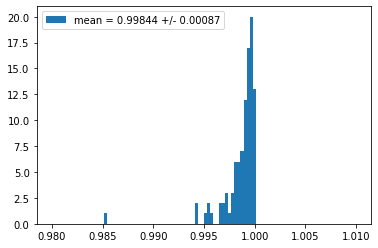

In [36]:
plt.hist(Pol,100,range=[0.98,1.01]);
#plt.ylim([0, 130])
plt.legend(["mean = "+str("{:.5f}".format(np.mean(Pol)))+" +/- "+str("{:.5f}".format(np.std(Pol)/np.sqrt(num_points))) ] )
plt.show
plt.savefig('Polarization.pdf')
#Pol